# **Phase 1: Setup**


Importing required libraries

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

Downloading the dataset

In [96]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -o ml-100k.zip

--2025-12-23 11:45:33--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.96.204
Connecting to files.grouplens.org (files.grouplens.org)|128.101.96.204|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.grouplens.org/datasets/movielens/ml-100k.zip [following]
--2025-12-23 11:45:33--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Connecting to files.grouplens.org (files.grouplens.org)|128.101.96.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip.2’

ml-100k.zip.2       100%[===================>]   4.70M  12.4MB/s    in 0.4s    

2025-12-23 11:45:33 (12.4 MB/s) - ‘ml-100k.zip.2’ saved [4924029/4924029]

Archive:  ml-100k.zip
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data      

Load ratings

In [97]:
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols)
ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Load movies data

In [98]:
movies_cols = ['movie_id', 'title', 'release_date', 'video_release_date',
               'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
               'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
               'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
               'Sci-Fi', 'Thriller', 'War', 'Western']

movies = pd.read_csv('ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')
movies.head()

,movie_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Basic stats

In [99]:
num_users = ratings['user_id'].nunique()
num_movies = ratings['movie_id'].nunique()
print("Number of users:", num_users)
print("Number of movies:", num_movies)

Number of users: 943
Number of movies: 1682


Rating distribution graph

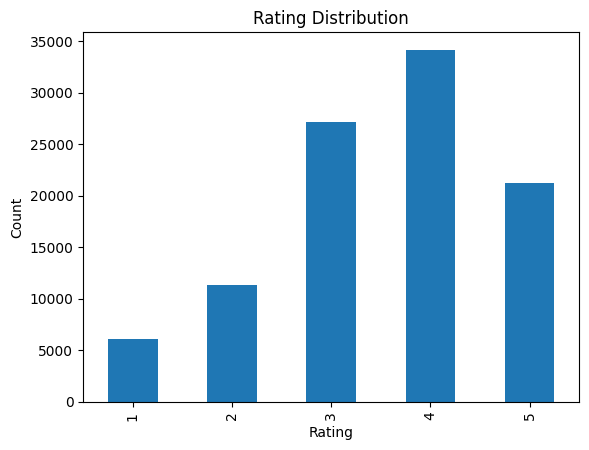

In [100]:
ratings['rating'].value_counts().sort_index().plot(kind='bar', title='Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

Calculating sparsity of user-movie matrix

In [101]:
sparsity = 1 - len(ratings) / (num_users * num_movies)
print("Sparsity of user-movie matrix:", sparsity)

Sparsity of user-movie matrix: 0.9369533063577546


# **Phase 2 : EDA**

Loading dataset

In [102]:
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols)

Ratings per user plot

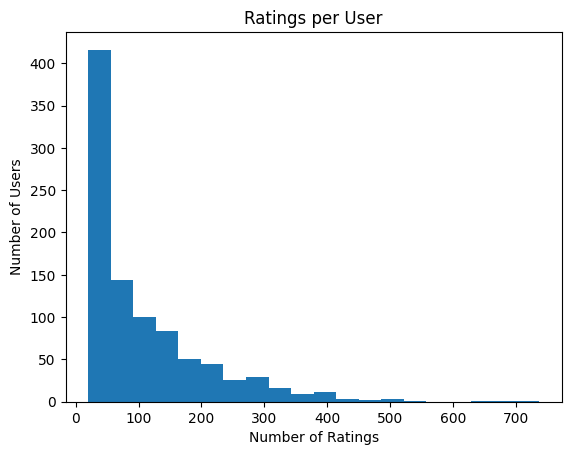

In [103]:
ratings_per_user = ratings.groupby('user_id')['rating'].count()
ratings_per_user.plot(kind='hist', bins=20, title='Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

Ratings per movie plot

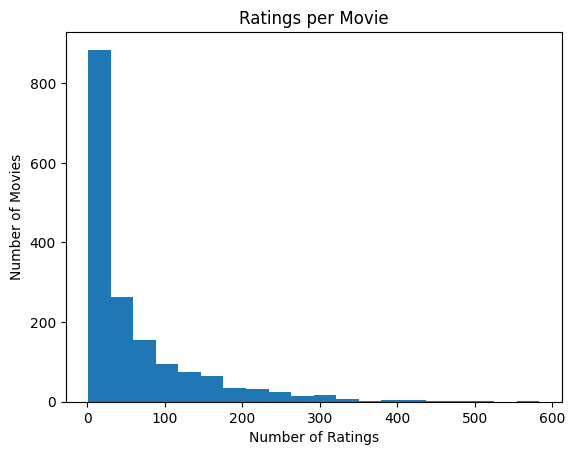

In [104]:
ratings_per_movie = ratings.groupby('movie_id')['rating'].count()
ratings_per_movie.plot(kind='hist', bins=20, title='Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.show()

Listing top movies by avg rating

In [105]:
top_movies = ratings.groupby('movie_id')['rating'].mean().sort_values(ascending=False).head(10)
print("Top 10 highest average rated movies:")
print(movies[movies['movie_id'].isin(top_movies.index)][['title']])

Top 10 highest average rated movies:
                                                  title
813                       Great Day in Harlem, A (1994)
1121                     They Made Me a Criminal (1939)
1188                                 Prefontaine (1997)
1200         Marlene Dietrich: Shadow and Light (1996) 
1292                                    Star Kid (1997)
1466               Saint of Fort Washington, The (1993)
1499                          Santa with Muscles (1996)
1535                               Aiqing wansui (1994)
1598                      Someone Else's America (1995)
1652  Entertaining Angels: The Dorothy Day Story (1996)


# **Phase 3 : Baseline Recommender**

In [106]:
movie_mean_ratings = ratings.groupby('movie_id')['rating'].mean()

movie_rating_count = ratings.groupby('movie_id')['rating'].count()

movie_popularity_scores = (0.7 * movie_mean_ratings) + (0.3 * movie_rating_count)

def popularity_recommender(top_n=10):
    top_movies = movie_popularity_scores.sort_values(ascending=False).head(top_n).index
    return movies[movies['movie_id'].isin(top_movies)][['movie_id','title']]

print("Top 10 Popular Movies:")
popularity_recommender()

Top 10 Popular Movies:


,movie_id,title
0,1,Toy Story (1995)
49,50,Star Wars (1977)
99,100,Fargo (1996)
120,121,Independence Day (ID4) (1996)
180,181,Return of the Jedi (1983)
257,258,Contact (1997)
285,286,"English Patient, The (1996)"
287,288,Scream (1996)
293,294,Liar Liar (1997)
299,300,Air Force One (1997)


## Item based collaborative filtering

Importing required libraries

In [107]:
from sklearn.metrics.pairwise import cosine_similarity

In [108]:
#Creating user-item matrix
user_item_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)

#Compute item-item similarity
item_similarity = cosine_similarity(user_item_matrix.T)  # Transpose to compare movies
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

Creating function for item based recommendations

In [109]:
def item_based_recommender(user_id, top_n=10):

    user_ratings = user_item_matrix.loc[user_id]

    scores = item_similarity_df.dot(user_ratings) # compute predicted scores

    scores = scores[user_ratings == 0] # remove already rated movies

    top_items = scores.sort_values(ascending=False).head(top_n).index # display top n movies

    return movies[movies['movie_id'].isin(top_items)][['movie_id','title']]

Testing item based recommender

In [110]:
print("Item-based Recommendations for User 1:")
item_based_recommender(1)

Item-based Recommendations for User 1:


,movie_id,title
317,318,Schindler's List (1993)
356,357,One Flew Over the Cuckoo's Nest (1975)
366,367,Clueless (1995)
384,385,True Lies (1994)
392,393,Mrs. Doubtfire (1993)
402,403,Batman (1989)
422,423,E.T. the Extra-Terrestrial (1982)
432,433,Heathers (1989)
567,568,Speed (1994)
654,655,Stand by Me (1986)


# **Phase - 4 : Collaborative Filtering using Matrix Factorisation(Singular Value Decomposition)**

Installing and importing required libraries

In [111]:
!pip install scikit-surprise

from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

Convert data for surprise

In [112]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)

Train-test split

In [113]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

Building SVD model

In [114]:
model = SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02)

Training the model

In [115]:
model.fit(trainset)

Evaluating along with RMSE(root mean squared error)

In [116]:
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)

RMSE: 0.9348


Function for making recommendations to a user

In [117]:
all_movie_ids = ratings['movie_id'].unique()

def svd_recommender(user_id, top_n=10):
    rated_movies = ratings[ratings['user_id'] == user_id]['movie_id']

    # predict ratings for unseen movies
    predictions = []
    for movie_id in all_movie_ids:
        if movie_id not in rated_movies.values:
            pred = model.predict(user_id, movie_id)
            predictions.append((movie_id, pred.est))

    # sort and retun top n movies
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_movie_ids = [movie_id for movie_id, _ in predictions[:top_n]]

    return movies[movies['movie_id'].isin(top_movie_ids)][['movie_id','title']]

Testing the SVD Recommender

In [118]:
print("SVD Recommendations for User 1:")
svd_recommender(1)

SVD Recommendations for User 1:


,movie_id,title
284,285,Secrets & Lies (1996)
301,302,L.A. Confidential (1997)
407,408,"Close Shave, A (1995)"
473,474,Dr. Strangelove or: How I Learned to Stop Worr...
479,480,North by Northwest (1959)
482,483,Casablanca (1942)
510,511,Lawrence of Arabia (1962)
512,513,"Third Man, The (1949)"
524,525,"Big Sleep, The (1946)"
922,923,Raise the Red Lantern (1991)


# **Phase 5 : Content Based Recommender**

Creating genre feature matrix

In [119]:
genre_cols = movies_cols[5:]
genre_matrix = movies[genre_cols]

Computing movie-movie similarity

In [120]:
genre_similarity = cosine_similarity(genre_matrix)
genre_similarity_df = pd.DataFrame(
    genre_similarity,
    index=movies['movie_id'],
    columns=movies['movie_id']
)

genre_similarity_df[50][172]  #testing

0.9128709291752769

Building content based recommender function

In [121]:
def content_based_recommender(user_id, top_n=10):
  #getting movies liked by the user
    user_ratings = ratings[ratings['user_id'] == user_id]
    liked_movies = user_ratings[user_ratings['rating'] >= 4]['movie_id']

  #computing similarity scores
    scores = pd.Series(0, index=movies['movie_id'])
    for movie_id in liked_movies:
        scores += genre_similarity_df[movie_id]
    scores = scores[~scores.index.isin(user_ratings['movie_id'])] #removing already seen movies

  #returning top N movies
    top_movie_ids = scores.sort_values(ascending=False).head(top_n).index
    return movies[movies['movie_id'].isin(top_movie_ids)][['movie_id','title']]

Testing content based recommender

In [122]:
print("Content-based Recommendations for User 1:")
content_based_recommender(1)

Content-based Recommendations for User 1:


,movie_id,title
480,481,"Apartment, The (1960)"
855,856,Night on Earth (1991)
1060,1061,"Evening Star, The (1996)"
1102,1103,Trust (1990)
1240,1241,"Van, The (1996)"
1332,1333,Midnight Dancers (Sibak) (1994)
1455,1456,Beat the Devil (1954)
1456,1457,Love Is All There Is (1996)
1459,1460,Sleepover (1995)
1587,1588,Salut cousin! (1996)


# **Phase 6 : Hybrid Recommender(Collaborative filtering + content based)**

Collaborative filtering score function using SVD

In [123]:
def get_cf_scores(user_id):
    """
    Predict ratings for all movies the user has NOT rated using SVD
    """
    rated_movies = ratings[ratings['user_id'] == user_id]['movie_id'].values
    all_movie_ids = movies['movie_id'].values

    cf_scores = {}

    for movie_id in all_movie_ids:
        if movie_id not in rated_movies:
            pred = model.predict(user_id, movie_id)
            cf_scores[movie_id] = pred.est  # predicted rating

    return cf_scores

Content based score function

In [124]:
def get_content_scores(user_id):

    #Compute content similarity score based on movies user liked

    user_ratings = ratings[ratings['user_id'] == user_id]

    liked_movies = user_ratings[user_ratings['rating'] >= 4]['movie_id'].values

    content_scores = {}

    for movie_id in movies['movie_id']:
        if movie_id not in liked_movies:
            score = 0
            for liked_movie in liked_movies:
                if liked_movie in genre_similarity_df.index:
                    score += genre_similarity_df.loc[liked_movie, movie_id]
            content_scores[movie_id] = score

    return content_scores

Normalising scores

In [125]:
def normalize_scores(score_dict):
    values = np.array(list(score_dict.values()))
    min_val, max_val = values.min(), values.max()

    if max_val - min_val == 0:
        return score_dict

    return {
        k: (v - min_val) / (max_val - min_val)
        for k, v in score_dict.items()
    }

Hybrid recommender

In [126]:
def hybrid_recommender(user_id, top_n=10, alpha=0.7):

    #Hybrid score = alpha * CF + (1 - alpha) * Content

    cf_scores = get_cf_scores(user_id)
    content_scores = get_content_scores(user_id)

    cf_scores = normalize_scores(cf_scores)
    content_scores = normalize_scores(content_scores)

    hybrid_scores = {}

    for movie_id in cf_scores:
        hybrid_scores[movie_id] = (
            alpha * cf_scores.get(movie_id, 0) +
            (1 - alpha) * content_scores.get(movie_id, 0)
        )

    top_movies = sorted(
        hybrid_scores.items(),
        key=lambda x: x[1],
        reverse=True
    )[:top_n]

    top_movie_ids = [movie_id for movie_id, _ in top_movies]

    return movies[movies['movie_id'].isin(top_movie_ids)][
        ['movie_id', 'title']
    ]

Testing hybrid recommender

In [127]:
hybrid_recommender(user_id=1, top_n=10, alpha=0.7)

,movie_id,title
284,285,Secrets & Lies (1996)
315,316,As Good As It Gets (1997)
426,427,To Kill a Mockingbird (1962)
474,475,Trainspotting (1996)
482,483,Casablanca (1942)
511,512,Wings of Desire (1987)
521,522,Down by Law (1986)
522,523,Cool Hand Luke (1967)
526,527,Gandhi (1982)
922,923,Raise the Red Lantern (1991)


# **Phase 7 : Evaluation & Comparison**

In [128]:
import random
random.seed(42)
np.random.seed(42)

Defining leave-one-out-Precision@10

In [129]:
import random

def precision_at_10_leave_one_out(recommender_fn, user_id, **kwargs):
    """
    Leave-one-out evaluation:
    - Hide one liked movie
    - Recommend Top-10
    - Check if hidden movie appears
    """

    user_data = ratings[ratings['user_id'] == user_id]
    liked_movies = user_data[user_data['rating'] >= 4]['movie_id'].values

    # Skip users with no liked movies
    if len(liked_movies) == 0:
        return None

    # Randomly hide one liked movie
    hidden_movie = random.choice(liked_movies)

    # Temporarily remove this rating
    mask = ~(
        (ratings['user_id'] == user_id) &
        (ratings['movie_id'] == hidden_movie)
    )
    temp_ratings = ratings[mask]

    # Swap ratings globally(temporary)
    global ratings_backup
    ratings_backup = ratings.copy()
    globals()['ratings'] = temp_ratings

    # Get recommendations
    recs = recommender_fn(user_id, top_n=10, **kwargs)

    # Restore original ratings
    globals()['ratings'] = ratings_backup

    # Check hit
    return int(hidden_movie in recs['movie_id'].values)


Evaluating a model across users

In [130]:
def evaluate_model(recommender_fn, users, **kwargs):
    scores = []

    for user_id in users:
        hit = precision_at_10_leave_one_out(
            recommender_fn,
            user_id,
            **kwargs
        )
        if hit is not None:
            scores.append(hit)

    return np.mean(scores)

Create a wrapper for popularity eval

In [131]:
def popularity_recommender_wrapper(user_id, top_n=10):
    # user_id is ignored (popularity is non-personalized)
    return popularity_recommender(top_n=top_n)

Run evaluation

In [132]:
test_users = ratings['user_id'].unique()[:50]

popularity_score = evaluate_model(popularity_recommender_wrapper, test_users)
cf_score = evaluate_model(svd_recommender, test_users)
hybrid_score = evaluate_model(hybrid_recommender, test_users, alpha=0.7)

popularity_score, cf_score, hybrid_score

(0.02, 0.08, 0.08)

Displaying results as a table

In [134]:
results_df = pd.DataFrame({
    'Model': ['Popularity', 'Collaborative Filtering', 'Hybrid'],
    'Precision@10': [popularity_score, cf_score, hybrid_score]
})

results_df

,Model,Precision@10
0,Popularity,0.02
1,Collaborative Filtering,0.08
2,Hybrid,0.08
